# AST 502 Final Project : Measuring galaxy shapes with Convolutional Neural Networks
## Pranjal RS

# Introduction

Gravitational lensing is the distortion of light from distant galaxies due to the tidal fields of the matter along the line of sight. By detecting the effects of the foreground lens (galaxy clusters) on the images of distant galaxies we can indirectly map the dark matter distribution. In strong gravitational lensing the effects can be very dramatic such as formation of arcs, rings, multiple images, etc. However, in weak gravitational lensing galaxy shapes are distorted at percent levels, and therefore separating the lensing signal from the intrinsic shape variations of the galaxies becomes very challenging. The lensing signal is therefore dominated by the shape noise. In my research project I'm working on Kinematic Lensing (https://arxiv.org/pdf/1311.1489.pdf), which is a new technique proposed to reduce the shape noise. The basic idea is to use galaxy kinematics obtained from spectroscopic measurements and the Tully-Fisher relation to infer the intrinsic galaxy shape. Once we have the intrinsic galaxy shape and the observed shape, it is straight forward to compute the shear signal. To summarize, we use the imaging data to measure the observed shape and the spectroscopic data to infer the instrinsic shape and by combining these two bits of information we can measure the shear signal. Currently, I use a Markov Chain to perform fits on both, the imaging and the spectroscopic data. I thought it would be interesting to explore other techniques of measuring galaxy shapes and found a recent paper (https://arxiv.org/pdf/1902.08161.pdf) which uses convolutional neural networks to measure galaxy shapes using the first data release of the DES. I tried implementing their neural network and tested it on simulated galaxy images.

# Building the Convolutional Neural Network
!<img src="./PRS_data/CNN.png" alt="Drawing" style="width: 800px;"/>
As the name suggests a convolutional neural network consists of layers which perform subsequent convolutions on the input image. It is very similar to the usual neural network but is designed to work with images or any other regularly sampled data. The basic idea is to reduce the image and extract only the most important features. Each convolution aims to extract a feature from the image which would be useful in the final classification. There are also other operations like max pooling which downsamples the the feature map of the image by taking the maximum value from the region of interest(the pixel window) and regularization which prevents both underfitting and overfitting. And finally we have a fully connected layer in which the output from the pooling layer is flattened out to a vector. Designing the CNN architecture is in itself a complicated task due to the large number of free parameters.

In [1]:
from keras.models import Sequential
import keras as keras
import keras.regularizers as kr
import keras.layers as kl
import pickle
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
reg = 5e-5
model = Sequential()

# Conv block
model.add(kl.Conv2D(16, kernel_size=(3, 3), padding='same', kernel_regularizer=kr.l2(reg), input_shape=(48, 48, 1)))
model.add(kl.Activation('relu'))
model.add(kl.BatchNormalization())
model.add(kl.Conv2D(16, kernel_size=(3, 3), padding='same', kernel_regularizer=kr.l2(reg)))
model.add(kl.Activation('relu'))
model.add(kl.BatchNormalization())
model.add(kl.MaxPooling2D(strides=(2,2)))

# Conv block
# model.add(kl.Conv2D(32, (3, 3),  padding='same', kernel_regularizer=kr.l2(reg)))
# model.add(kl.Activation('relu'))
# model.add(kl.BatchNormalization())
# model.add(kl.Conv2D(32, (3, 3),  padding='same', kernel_regularizer=kr.l2(reg)))
# model.add(kl.Activation('relu'))
# model.add(kl.BatchNormalization())
# model.add(kl.MaxPooling2D(strides=(2,2)))

# Conv block 
# model.add(kl.Conv2D(64, (3, 3),  padding='same', kernel_regularizer=kr.l2(reg)))
# model.add(kl.Activation('relu'))
# model.add(kl.BatchNormalization())
model.add(kl.Conv2D(32, (1, 1),  padding='same', kernel_regularizer=kr.l2(reg)))
model.add(kl.Activation('relu'))
model.add(kl.BatchNormalization())
model.add(kl.Conv2D(64, (3, 3),  padding='same', kernel_regularizer=kr.l2(reg)))
model.add(kl.Activation('relu'))
model.add(kl.BatchNormalization())
model.add(kl.MaxPooling2D(strides=(2,2)))

# Conv block
# model.add(kl.Conv2D(128, (3, 3),  padding='same', kernel_regularizer=kr.l2(reg)))
# model.add(kl.Activation('relu'))
# model.add(kl.BatchNormalization())
model.add(kl.Conv2D(64, (1, 1),  padding='same', kernel_regularizer=kr.l2(reg)))
model.add(kl.Activation('relu'))
model.add(kl.BatchNormalization())
# model.add(kl.Conv2D(128, (3, 3),  padding='same', kernel_regularizer=kr.l2(reg)))
# model.add(kl.Activation('relu'))
# model.add(kl.BatchNormalization())
model.add(kl.MaxPooling2D(strides=(4,4)))

# Conv block
model.add(kl.Conv2D(256, (3, 3),  padding='same',kernel_regularizer=kr.l2(reg)))
model.add(kl.Activation('relu'))
model.add(kl.BatchNormalization())
model.add(kl.Conv2D(128, (1, 1),  padding='same',kernel_regularizer=kr.l2(reg)))
model.add(kl.Activation('relu'))
model.add(kl.BatchNormalization())
model.add(kl.Conv2D(256, (3, 3),  padding='same',kernel_regularizer=kr.l2(reg)))
model.add(kl.Activation('relu'))
model.add(kl.BatchNormalization())
          
# End of convolution
model.add(kl.GlobalAveragePooling2D())
model.add(kl.Dense(1))


model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(lr=0.05),
              metrics=['mean_absolute_error'])

In [3]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 16)        160       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 16)        2320      
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)       

The $summary()$ attribute shows us the complete architecture of the CNN code. It lists all the layers, the shape the data vector will have after it goes through it along with the total number of parameters required. For example, the first layer is a 3x3 convolution layer with 16 nodes. There each node will have 9 elements for the convolution matrix and a weight associated with that node giving us a total of 10 parameters per node. And therefore the first layer has $10*16$ = 160 paramaters. This more complex for subsequent layers as every node is connected to evevery other node in the next layer and we therefore have even larger number of parameters.

Next we proceed to import the testing and training data. Since Keras requires a 3D data vector we need to reshape the images so that they the shape 48x48x1.  Since, I am currently working with simulation data I used the Galsim package in Python to generate galaxy images of varying sizes and ellipticities, which serves as the testing and training data set. The training and testing set comprise of 10000 and 500 images respectively.

In [4]:
def load_obj(name ):
    with open('./PRS_data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
training = load_obj('training_data')
testing = load_obj('testing_data')

x_train, y_train = [], []
for key, value in training.items():
    image = value[0]/np.max(value[0])
    image = np.expand_dims(image, axis=3)
    
    x_train.append(image)
    y_train.append(value[1])
    
x_test, y_test = [], []
for key, value in testing.items():
    image = value[0]/np.max(value[0])
    image = np.expand_dims(image, axis=3)
    
    x_test.append(image)
    y_test.append(value[1])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

/home/pranjalrs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  # This is added back by InteractiveShellApp.init_path()
/home/pranjalrs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


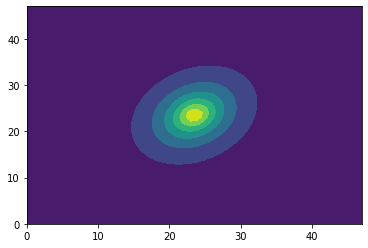

In [5]:
# See what the images look like
plt.contourf(x_train[0][:,:,0])

In [6]:
history = []
history = model.fit(x_train, y_train,
          epochs=20, verbose = 0,
          validation_data=(x_test, y_test))

In [7]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0292070172727108
Test accuracy: 0.9800847768783569


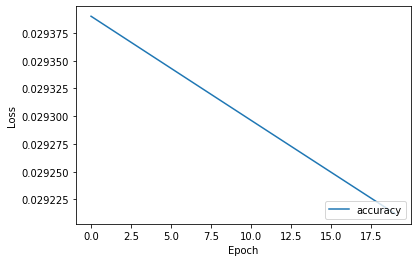

In [8]:
plt.plot(history.history['loss'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

In [9]:
# Test prediction on a couple of test values
predictions = model.predict(x_train[:11])
for i, y in enumerate(y_train[:10]):
    print("Shape: {}, Prediction: {}".format(y, predictions[i][0]))

Shape: 0.31776211577462304, Prediction: -0.5828977823257446
Shape: 0.23720257118455934, Prediction: -0.35281169414520264
Shape: 0.019553605587253442, Prediction: -0.42636334896087646
Shape: 0.28171707242605204, Prediction: -0.8364741802215576
Shape: 0.0942329895532984, Prediction: -0.7739650011062622
Shape: 0.05360451193221255, Prediction: -0.6378843784332275
Shape: 0.34051708700154404, Prediction: -0.9739903211593628
Shape: 0.35021720342978524, Prediction: -0.6387805938720703
Shape: 0.35997403352802504, Prediction: -0.6912142038345337
Shape: 0.23886423968259035, Prediction: -1.217195749282837


<img src="./PRS_data/loss.png" alt="Drawing" style="width: 400px;"/>


# Conclusions
Unfortunately, the model performs very poorly and has a very low accuracy. The loss function which is sometimes referred to as the cost function tells us about the learning rate of our network. The above plot for the loss shows that the current network has a very low learning rate and therefore would take a very long time before it begins to converge. Increasing the number of epochs improves the accuracy but not by a signficant margin. For example, doubling the number of epochs from 20 to 40 improves the accuracy by 0.002. Adding regularization and batch normalization doesn't change the peformance of the model either. This indicates a problem with the network architecture itself and therefore we would need to perform tests like check magnitudes of loss weights, performing a grid search for hyperparameters, checking weight initializations, etc. One could also monitor the weights and updates for each layer during the training.

However, the CNN used by the authors was able to match the precision of the maximum likelihood shape estimates for bright galaxies and infact significantly outperformed it on fainter galaxies. 

References: 
Dezső Ribli, László Dobos, István Csabai,  2019, https://arxiv.org/pdf/1902.08161.pdf